<h1 align="center">GNNs - Master in Deep Learning of UPM</h1>

Deberéis descomentar esta celda si no disponéis del setup necesario para trabajar con Pytorch Geometric o si estáis en Colab :).

In [33]:
# %%capture
# import torch

# def format_pytorch_version(version):
#   return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#   return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install pyg-lib           -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric 

In [34]:
import os
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from torch_geometric.utils import from_networkx, to_networkx, softmax, scatter
from torch_geometric.loader import NeighborLoader, ClusterData, ClusterLoader, GraphSAINTRandomWalkSampler, GraphSAINTNodeSampler, GraphSAINTEdgeSampler
from torch_geometric.datasets import CitationFull, TUDataset
from torch_geometric.nn import GIN, GCN, MLP, global_mean_pool, Aggregation

# Batcheo de Grafos

Crearemos un grafo de ejemplo para visualizar como funcionan los diferentes algoritmos que hemos aprendido

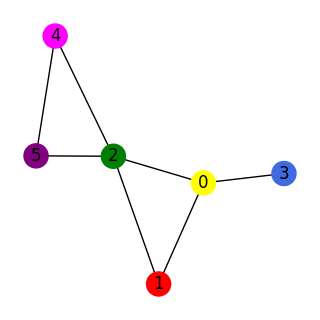

In [35]:
G = nx.from_edgelist([
    (0, 1), 
    (0, 2), 
    (0, 3), 
    (1, 2), 
    (2, 4), 
    (2, 5), 
    (4, 5)
])

plt.figure(figsize=(3, 3))
colors = {
    0: "yellow",
    1: "red",
    2: "green",
    3: "royalblue",
    4: "magenta",
    5: "purple"
}

nx.draw(G, with_labels=True, node_color=[colors[i] for i in range(6)])

*NO TOCAR*

Algunas funciones para dibujar los diferentes dataloaders

In [36]:
def draw_batch(sub_data, ax, title):
    original_edges = sub_data.n_id[sub_data.edge_index]
    G_batch = nx.from_edgelist(original_edges.T.numpy())

    node_colors = [colors[n.item()] for n in sub_data.n_id]
    edge_colors = ["black"]*sub_data.batch_size + ["white"]*(len(sub_data.n_id) - sub_data.batch_size)

    nx.draw(
        G_batch, 
        ax=ax,
        with_labels=True, 
        node_color=node_colors, 
        edgecolors=edge_colors,
        nodelist=sub_data.n_id.tolist(),
        linewidths=2,
    )
    ax.set_title(title)

def draw_batch_cluster(sub_data, ax, title, node_coms=None):
    g_batch = to_networkx(sub_data, to_undirected=True)
    node_labels = {n:sub_data.id[n].item() for n in g_batch.nodes()}
    node_colors = [node_coms[sub_data.id[n].item()] for n in g_batch.nodes()]
    pos = nx.spring_layout(g_batch, k=0.75)
    nx.draw_networkx(g_batch, pos=pos, with_labels=True, labels=node_labels, node_color=node_colors, ax=ax)
    ax.set_title(title)

def draw_batch_saintnode(sub_data, ax, title):
    g_batch = to_networkx(sub_data, to_undirected=True)
    nx.relabel_nodes(g_batch, {n: sub_data.id[n].item() for n in g_batch.nodes()}, copy=False)
    node_colors = sub_data.node_norm.tolist()
    edge_colors = sub_data.edge_norm.tolist()

    pos = nx.spring_layout(g_batch, k=0.5)
    nx.draw_networkx(
        g_batch, 
        pos=pos, 
        with_labels=True, 
        ax=ax, 
        node_color=node_colors,
        cmap="Blues",
        edge_color=edge_colors,
        edge_cmap=plt.cm.plasma,
        nodelist=sub_data.id.tolist(), 
        edgelist=sub_data.id[sub_data.edge_index].T.tolist(), 
        edgecolors="navy"
    )
    ax.set_title(title)

def draw_loader(loader, draw_batch_fn=draw_batch, **kwargs):
    num_batches = len(loader)

    cols = 3
    rows = (num_batches + cols - 1) // cols 
    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 5)) 

    axs = axs.flatten()

    for i, batch in enumerate(loader):
        draw_batch_fn(batch, axs[i], f'Batch {i}', **kwargs)

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

# GraphSAGE 

Ya existe una implementación genérica de este método disponile en PyTorch Geometric como [NeighborLoader](https://pytorch-geometric.readthedocs.io/en/2.5.1/modules/loader.html#torch_geometric.loader.NeighborLoader).

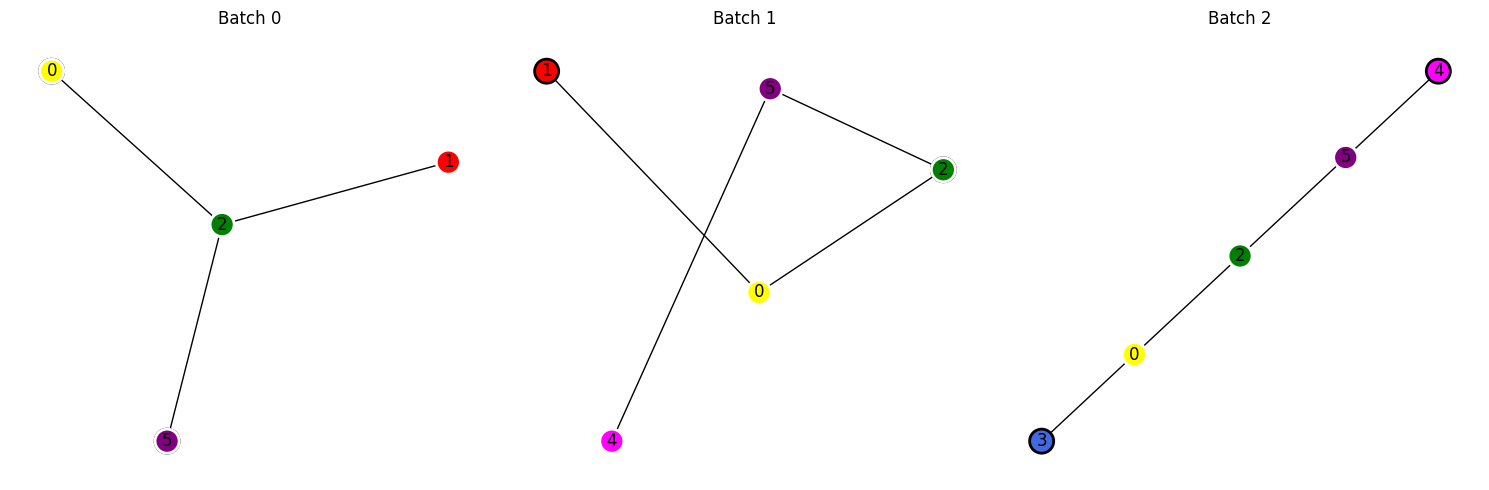

In [37]:
data = from_networkx(G)  # Convertir el grafo a un objeto de PyG

batch_size = 2
num_neighbors = [1, 2]
shuffle = True
disjoint = True

graphSAGELoader = NeighborLoader(
    data=data,  # Dataset
    batch_size=batch_size,  # Número de nodos por batch
    num_neighbors=num_neighbors,  # Número de vecinos a considerar
    shuffle=shuffle,  # Coger nodos aleatorios cada vez
    disjoint=disjoint  # Si los nodos escogidos deben ser disjuntos
)

draw_loader(graphSAGELoader, draw_batch_fn=draw_batch)

¿Cómo se trabaja a nivel de batch?

Por defecto se convierte el grafo en dirigido, lo que pasa a significar que no es lo mismo la arista _a->b_ que la _b->a_ por lo que al imprimir las aristas se pueden ver "repetidas".

Batch 0
Nodos seleccionados: tensor([3, 4])
Nodos expandidos: tensor([3, 4, 0, 2, 2, 0])
Aristas: tensor([[0, 2, 2, 3, 0, 4],
        [3, 4, 0, 0, 2, 2]])
Atributos de los nodos: None


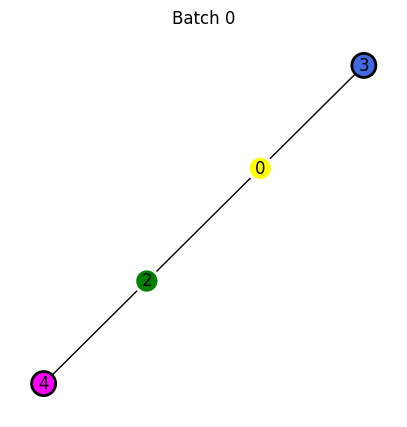

In [38]:
data = from_networkx(G)  # Convertir el grafo a un objeto de PyG

batch_size = 2
num_neighbors = [1, 2]
shuffle = True
disjoint = True

graphSAGELoader = NeighborLoader(
    data=data,  # Dataset
    batch_size=batch_size,  # Número de nodos por batch
    num_neighbors=num_neighbors,  # Número de vecinos a considerar
    shuffle=shuffle,  # Coger nodos aleatorios cada vez
    disjoint=disjoint  # Si los nodos escogidos deben ser disjuntos
)

fig, ax = plt.subplots(1, figsize=(5, 5))

for i, batch in enumerate(graphSAGELoader):
    print(f"Batch {i}")
    print(f"Nodos seleccionados: {batch.input_id}")
    print(f"Nodos expandidos: {batch.n_id}")
    print(f"Aristas: {batch.n_id[batch.edge_index]}")
    print(f"Atributos de los nodos: {batch.x}")
    
    draw_batch(batch, ax, f'Batch {i}')
    break  # Mostrar solo el primer batch

Carguemos un dataset y entrenemos una red GIN utilizando el dataloader

In [39]:
def split_dataset(dataset, test_size=0.2):
    if len(dataset) == 1: # Si solo hay un grafo en el dataset
        data = dataset[0]
    
    train_idx, test_idx = train_test_split(np.arange(data.num_nodes), test_size=test_size, stratify=data.y)

    train_mask = np.zeros(data.num_nodes, dtype=bool)
    train_mask[train_idx] = True

    test_mask = np.zeros(data.num_nodes, dtype=bool)
    test_mask[test_idx] = True

    data.train_mask = torch.tensor(train_mask)
    data.test_mask = torch.tensor(test_mask)

    return data

Concretamente cargaremos el dataset de *Cora*, conteniendo 2708 publicaciones científicas divididas en 7 clases. Éstas están conectadas a través de un total de 5429 aristas que representan citaciones. El objetivo será clasificar correctamente la clase de la publicación dado su contexto de citas.

In [40]:
dataset = CitationFull(root='CitationFull', name='Cora_ML')
data = split_dataset(dataset, test_size=0.2)

Creamos un clasificador basado en una red GIN y un MLP

In [41]:
class GINMLP(nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels=32, n_layers=2):
        super(GINMLP, self).__init__()
        self.gin = GIN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
            dropout=0.5,
            act="relu",
            jk="cat"   
        )
        self.cls = MLP(
            in_channels=hidden_channels, 
            hidden_channels=hidden_channels,
            out_channels=num_classes, 
            num_layers=2,
            dropout=0.5
        )
    
    def reset_parameters(self):
        self.gin.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, batch, edge_weight=None):
        x, edge_index = batch.x, batch.edge_index
        x = self.gin(x, edge_index, edge_weight)
        x = self.cls(x)
        return x

Algunas funciones que nos permitan entrenar y evaluar con PyTorch

In [42]:
def train(model, train_loader, optimizer, criterion, device, epoch_fn=None, epochs=100, print_every=5):
    model.train()
    for epoch in range(epochs):
        loss = epoch_fn(model, train_loader, optimizer, criterion, device)
        
        if epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss {loss}")

    return model

def test(model, data):
    model.eval()
    out = model(data)
    y_pred = out.argmax(dim=1)[data.test_mask].tolist()
    y_true = data.y[data.test_mask].tolist()
        
    return y_true, y_pred

In [43]:
def graph_sage_epoch(model, train_loader, optimizer, criterion, device):
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        
        optimizer.zero_grad()
        # calculamos el nuevo peso de las aristas en base a la normalizacion de alpha
        out = model(batch)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])

        # paso de optimizacion
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(train_loader)

Epoch 0: Loss 1.0406810105481046
Epoch 5: Loss 0.2296975388171825
Epoch 10: Loss 0.1885861429445287
Epoch 15: Loss 0.16640393364619702
Epoch 20: Loss 0.15762044869838876
F1 Score: 0.8480801335559266


<Axes: >

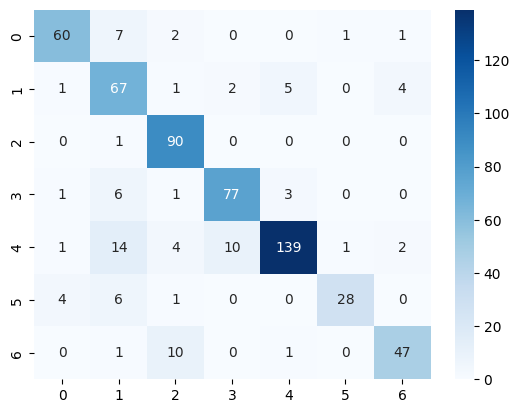

In [44]:
# Entrenar el modelo
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GINMLP(num_features=dataset.num_features, num_classes=dataset.num_classes)
model.reset_parameters()
model = model.to(device)

neis = [25, 10]
batch_size = 32
train_loader = NeighborLoader(data, batch_size=batch_size, num_neighbors=neis, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = CrossEntropyLoss()
criterion = criterion.to(device)

model = train(
    model, 
    train_loader, 
    optimizer, 
    criterion, 
    device, 
    epoch_fn=graph_sage_epoch, 
    epochs=25
) # Entrenar el modelo

# Evaluar el modelo
y, y_pred = test(model, data) # Evaluar el modelo

f1 = f1_score(y, y_pred, average='micro')
print(f"F1 Score: {f1}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Cluster Sampling

* Disponible en la clase [ClusterLoader](https://pytorch-geometric.readthedocs.io/en/2.5.1/modules/loader.html#torch_geometric.loader.ClusterLoader), dada una estructura de comunidad implementa el loader de datos.
* Disponible en la clase [ClusterData](https://pytorch-geometric.readthedocs.io/en/2.5.1/modules/loader.html#torch_geometric.loader.ClusterData), implementa el algoritmo de METIS para detección de comunidades.

Cargaremos el dataset de KarateClub para ilustrar esta técnica de sampleo.

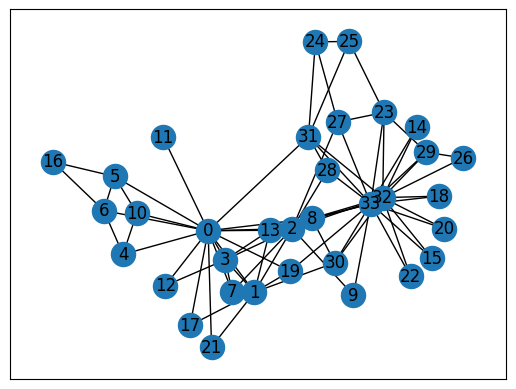

In [45]:
G = nx.karate_club_graph()
nx.set_node_attributes(G, {n: [G.degree(n)] for n in G.nodes()}, "x")
nx.set_node_attributes(G, {n: n for n in G.nodes()}, "id")

for n in G.nodes():
    G.nodes[n].pop("club")

for u, v in G.edges():
    G[u][v].pop("weight")

data = from_networkx(G)

nx.draw_networkx(G, with_labels=True)

/tmp/ipykernel_2323974/1323927401.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap("tab10", num_clusters)  # Puedes usar cualquier colormap disponible en matplotlib
Computing METIS partitioning...
Done!


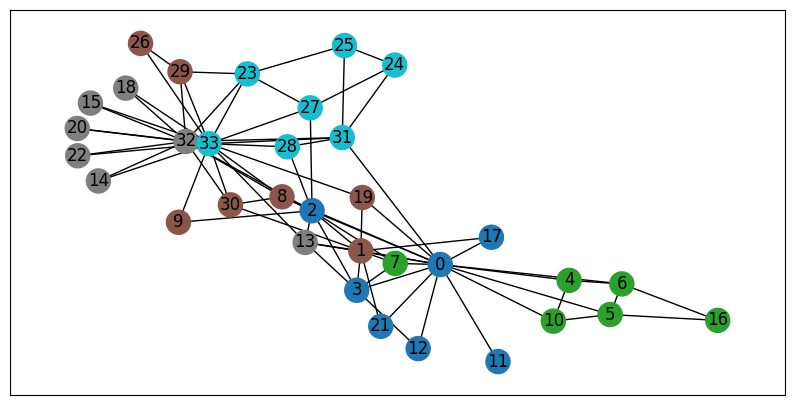

In [46]:
# Número de comunidades
num_clusters = 5

# Generar colores dinámicamente usando un colormap
colormap = cm.get_cmap("tab10", num_clusters)  # Puedes usar cualquier colormap disponible en matplotlib
com_colors = {i: colormap(i) for i in range(num_clusters)}

# Definimos ClusterData y ClusterLoader
cluster_data = ClusterData(data, num_parts=num_clusters)
loader = ClusterLoader(cluster_data, batch_size=1)

# Asignar colores a los nodos en función de su comunidad
node_coms = {}
for i, b in enumerate(loader):
    node_coms.update({n.item(): com_colors[i] for n in b.id})

# Crear copia del grafo y asignar atributos de comunidad
G_coms = G.copy()
nx.set_node_attributes(G_coms, node_coms, "com")

# Dibujar el grafo con colores de comunidad
plt.figure(figsize=(10, 5))
nx.draw_networkx(
    G_coms,
    with_labels=True,
    node_color=[r["com"] for _, r in G_coms.nodes(data=True)],
)
plt.show()

Computing METIS partitioning...
Done!


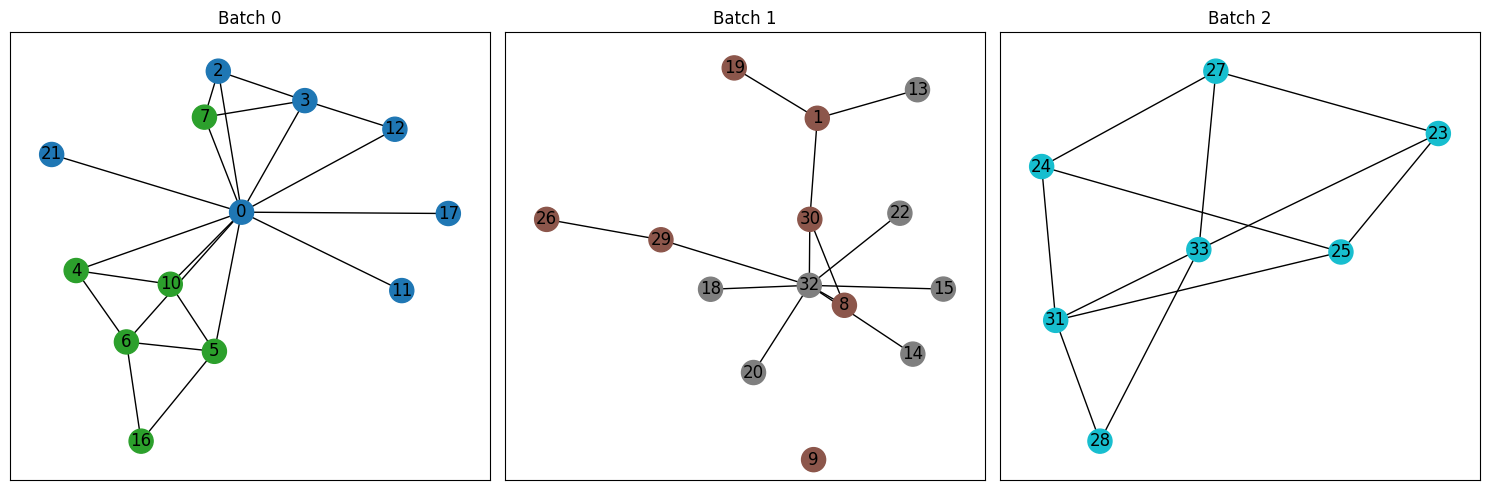

In [47]:
num_clusters = 5

# Definimos ClusterData y ClusterLoader
cluster_data = ClusterData(data, num_parts=num_clusters, keep_inter_cluster_edges=True)
loader = ClusterLoader(cluster_data, batch_size=2)

# Crear copia del grafo y asignar atributos de comunidad
G_coms = G.copy()
nx.set_node_attributes(G_coms, node_coms, "com")

# Dibujar el grafo con colores de comunidad
draw_loader(loader, draw_batch_fn=draw_batch_cluster, node_coms=node_coms)

In [48]:
dataset = CitationFull(root='CitationFull', name='Cora_ML')
data = split_dataset(dataset, test_size=0.2)

In [49]:
def cluster_sampling_epoch(model, train_loader, optimizer, criterion, device):
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        
        optimizer.zero_grad()
        # calculamos el nuevo peso de las aristas en base a la normalizacion de alpha
        out = model(batch)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])

        # paso de optimizacion
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(train_loader)

Computing METIS partitioning...
Done!


Epoch 0: Loss 2.0447168350219727
Epoch 25: Loss 1.1274951696395874
Epoch 50: Loss 0.4714958071708679
Epoch 75: Loss 0.21137242019176483
Epoch 100: Loss 0.1409328281879425
Epoch 125: Loss 0.13508513569831848
Epoch 150: Loss 0.10747754573822021
Epoch 175: Loss 0.11583684384822845
Epoch 200: Loss 0.09834592044353485
Epoch 225: Loss 0.10054127871990204
Epoch 250: Loss 0.07683860510587692
Epoch 275: Loss 0.07295532524585724
Epoch 300: Loss 0.07335914671421051
Epoch 325: Loss 0.06911811232566833
Epoch 350: Loss 0.06472419202327728
Epoch 375: Loss 0.06704176217317581
Epoch 400: Loss 0.08605952560901642
Epoch 425: Loss 0.07134538888931274
Epoch 450: Loss 0.055655039846897125
Epoch 475: Loss 0.04677266255021095
Epoch 500: Loss 0.07318157702684402
F1 Score: 0.8247078464106845


<Axes: >

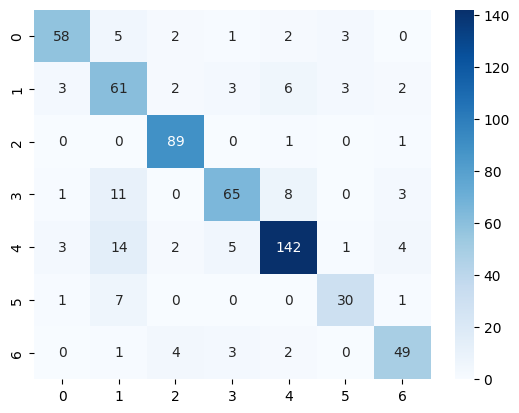

In [50]:
# Entrenar el modelo
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GINMLP(num_features=dataset.num_features, num_classes=dataset.num_classes)
model.reset_parameters()
model = model.to(device)

num_clusters = 10
batch_size = 10

# Definimos ClusterData y ClusterLoader
cluster_data = ClusterData(data, num_parts=num_clusters, keep_inter_cluster_edges=True)
train_loader = ClusterLoader(cluster_data, batch_size=batch_size)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = CrossEntropyLoss()
criterion = criterion.to(device)

model = train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epoch_fn=cluster_sampling_epoch,
    epochs=501,
    print_every=25
)

# Evaluar el modelo
y, y_pred = test(model, data) # Evaluar el modelo

f1 = f1_score(y, y_pred, average='micro')
print(f"F1 Score: {f1}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# GraphSAINT

* [GraphSAINTNodeSampler](https://pytorch-geometric.readthedocs.io/en/stable/modules/loader.html#torch_geometric.loader.GraphSAINTNodeSampler): Muestra nodos al azar siendo la probabilidad de elegir cada nodo $ P(u) \propto \left\| \tilde{A}_{:,u} \right\|^2 $
* [GraphSAINTEdgeSampler](https://pytorch-geometric.readthedocs.io/en/stable/modules/loader.html#torch_geometric.loader.GraphSAINTEdgeSampler): Muestre aristas al azar siendo la probabilidad de elegir cada arista $ P(e_{u,v}) \propto \frac{1}{\text{deg}(u)} + \frac{1}{\text{deg}(v)}$
* [GraphSAINTRandomWalkSampler](https://pytorch-geometric.readthedocs.io/en/stable/modules/loader.html#torch_geometric.loader.GraphSAINTRandomWalkSampler): Se realizan $r$ nodos al azar siguiendo una distribución uniforme y luego se realizan caminos aleatorios de longitud $h$ empezando en cada nodo.

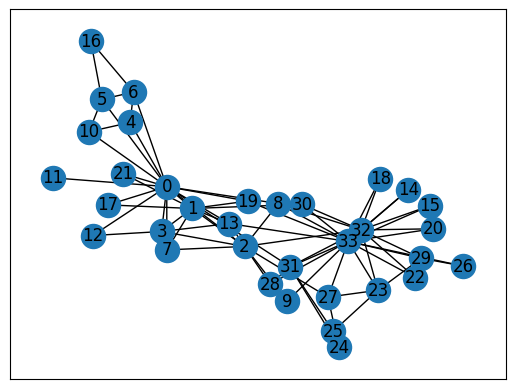

In [51]:
G = nx.karate_club_graph()
nx.set_node_attributes(G, {n: [G.degree(n)] for n in G.nodes()}, "x")
nx.set_node_attributes(G, {n: n for n in G.nodes()}, "id")

for n in G.nodes():
    G.nodes[n].pop("club")

for u, v in G.edges():
    G[u][v].pop("weight")

data = from_networkx(G)

nx.draw_networkx(G, with_labels=True)

### Node Sampler
* `batch_size`: Nº de nodos elegidos (aprox)
* `num_steps`: Nº de grafos generados

Compute GraphSAINT normalization: : 3405it [00:00, 83590.02it/s]          


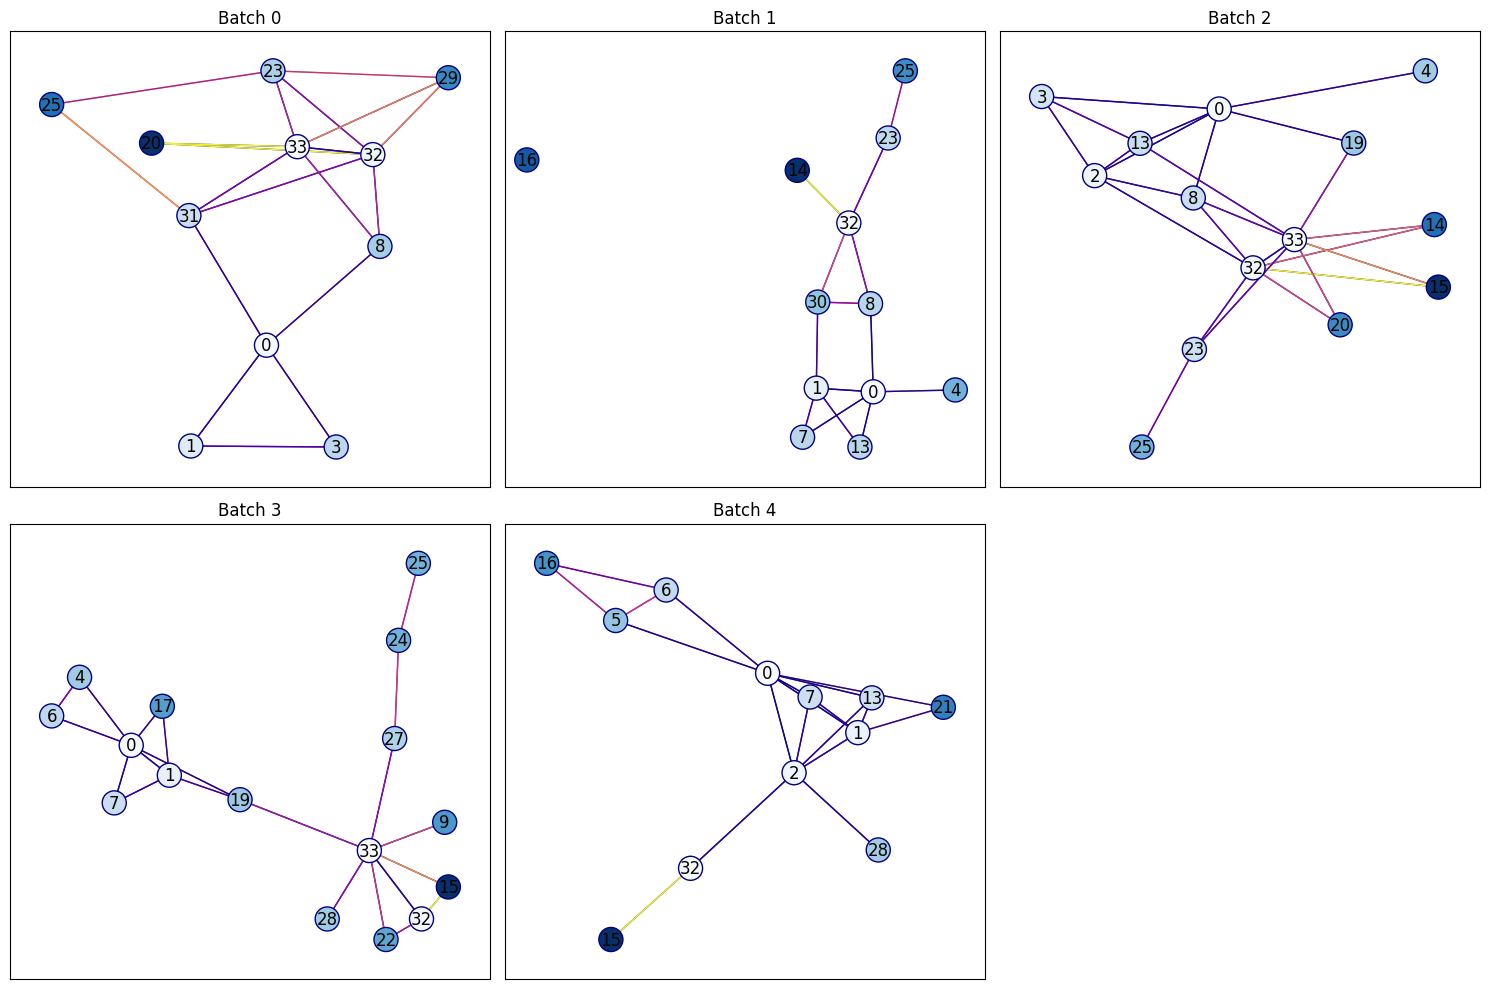

In [52]:
loader = GraphSAINTNodeSampler(data, num_steps=5, batch_size=16, sample_coverage=100)
draw_loader(loader, draw_batch_fn=draw_batch_saintnode)

### Edge sampler

* `batch_size`: Nº de aristas elegidas (aprox)
* `num_steps`: Nº de grafos generados

Compute GraphSAINT normalization: : 373it [00:00, 22396.68it/s]          


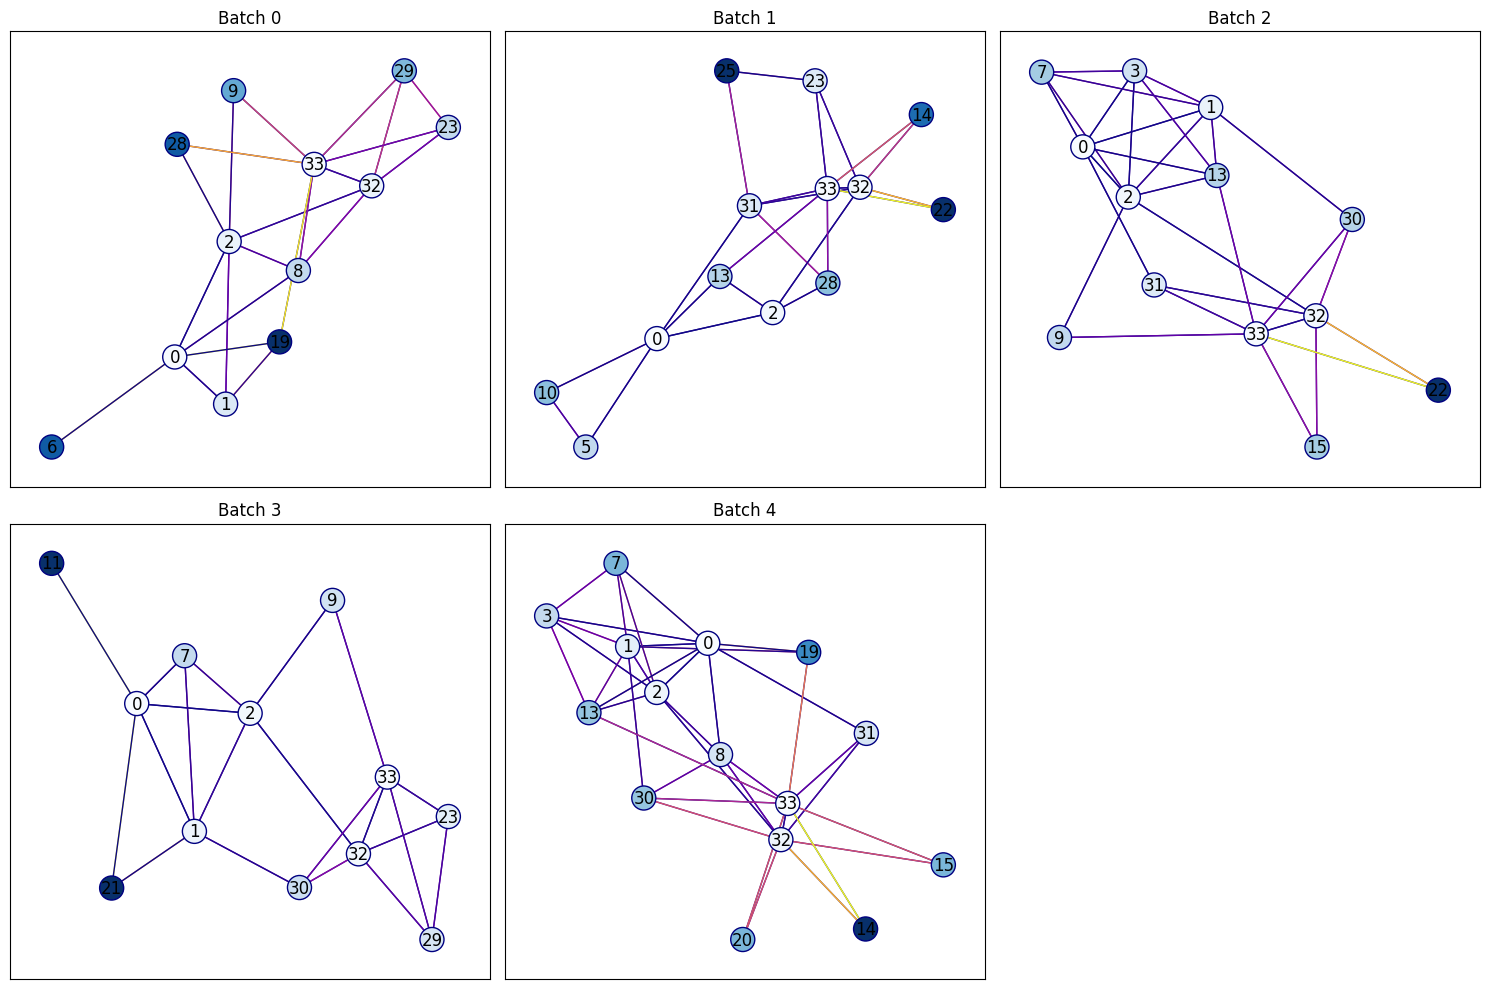

In [53]:
loader = GraphSAINTEdgeSampler(data, num_steps=5, batch_size=10, sample_coverage=10)
draw_loader(loader, draw_batch_fn=draw_batch_saintnode)

### Random walks

* `batch_size`: Nº de nodos desde donde se inciarán los caminos aleatorios
* `walk_length`: Longitud de cada uno de los caminos que se inicien
* `num_steps`: Nº de grafos generados

Compute GraphSAINT normalization: : 363it [00:00, 38369.30it/s]          


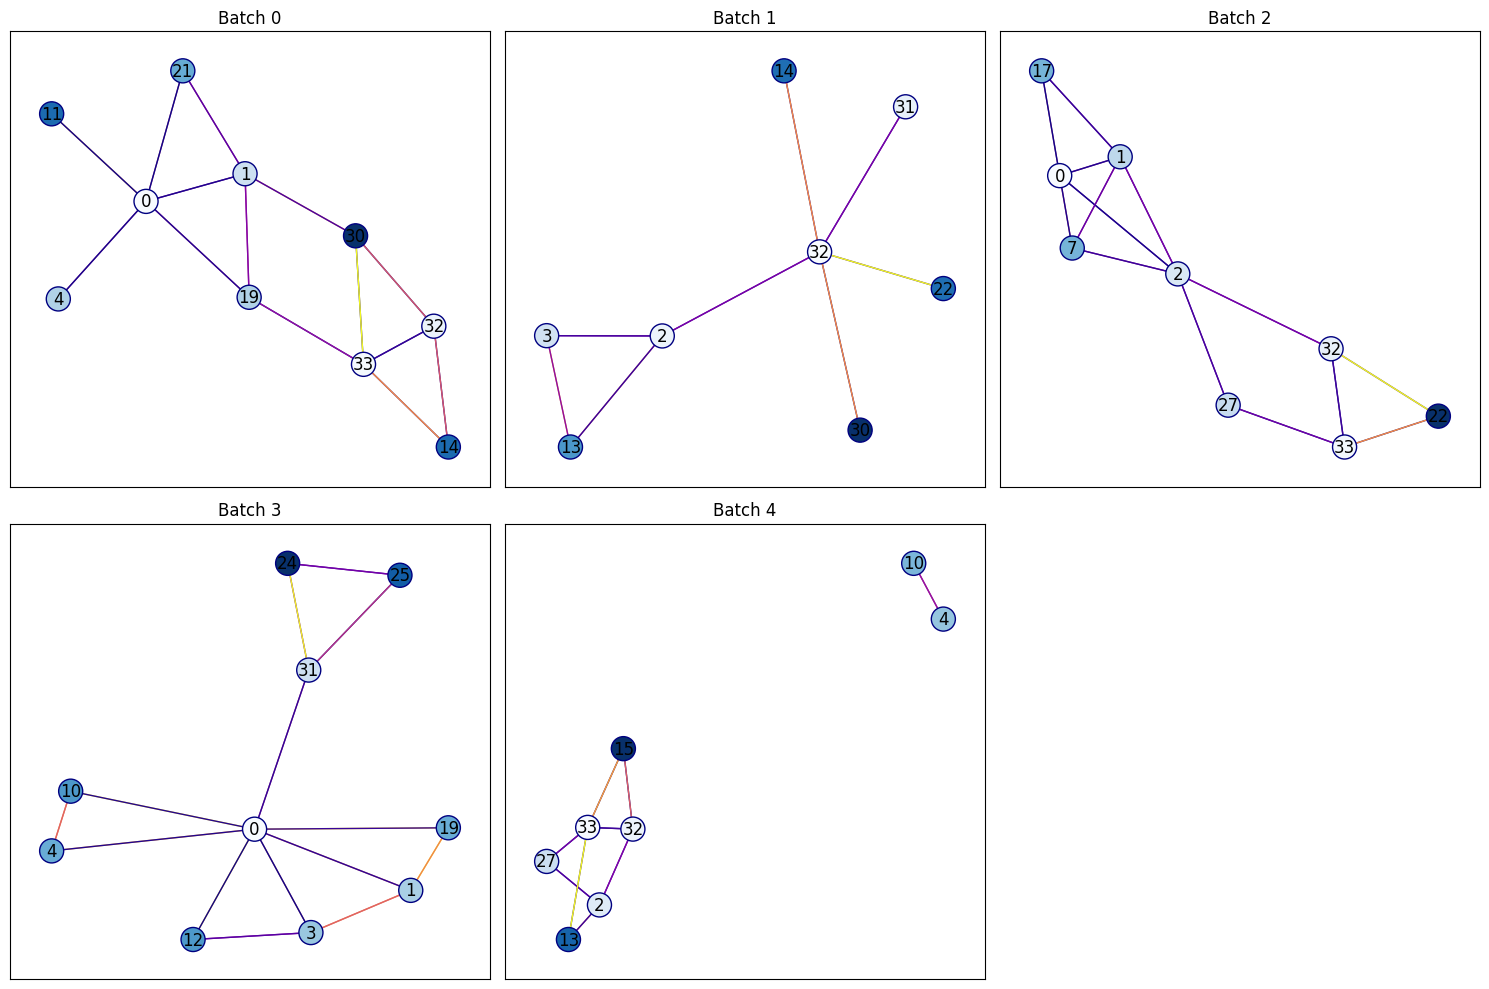

In [54]:
loader = GraphSAINTRandomWalkSampler(data, walk_length=3, num_steps=5, batch_size=3, sample_coverage=10)
draw_loader(loader, draw_batch_fn=draw_batch_saintnode)

GraphSaint nos da ciertos pesos a nivel de nodo (normalización para la función de pérdida) y a nivel de arista (normalización a la hora de agregar).

¿Cómo los tenemos en cuenta en el entrenamiento?

In [55]:
dataset = CitationFull(root='CitationFull', name='Cora_ML')
data = split_dataset(dataset, test_size=0.2)

Atributos Importantes:

1. `node_norm`:

    - Representa los coeficientes de normalización para los nodos en el mini-batch.
    - Se utiliza para ajustar las contribuciones de los nodos según su probabilidad de ser muestreados.
    - Se aplica ponderando la función de pérdida de forma que nodos menos probables de salir durante el sampleo tengan más relevancia.
2. `edge_norm`:

    - Representa los coeficientes de normalización para las aristas en el mini-batch.
    - Compensa el sesgo causado por el método de muestreo de aristas (como en el caso de EdgeSampler).
    - Ajusta las contribuciones de las aristas en la agregación de mensajes.

In [56]:
def graph_saint_epoch(model, train_loader, optimizer, _, device):
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        
        optimizer.zero_grad()
        out = model(batch, edge_weight=batch.edge_norm)

        out = out.log_softmax(dim=-1) # Aplicar log_softmax a las predicciones
        
        # calculamos el cross entropy loss en dos pasos, primero calculamos la loss para cada nodo
        # luego aplicamos la normalizacion de lambdas y luego sumamos las losses
        loss = F.nll_loss(out, batch.y, reduction='none')
        loss = (loss * batch.node_norm)[batch.train_mask].sum()

        # paso de optimizacion
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(train_loader)

Cada arista recibe un peso inversamente proporcional al grado del nodo destino. Es decir:
- Si un nodo tiene un grado alto (muchas conexiones), sus aristas reciben menos peso.
- Si un nodo tiene un grado bajo, sus aristas reciben más peso.

El resultado es una normalización de las aristas que asegura que las contribuciones de los nodos estén balanceadas en términos de su grado.

Compute GraphSAINT normalization:   0%|          | 0/299500 [00:00<?, ?it/s]

Compute GraphSAINT normalization: : 299506it [00:00, 616467.92it/s]                          


Epoch 0: Loss 1.5013376116752624
Epoch 5: Loss 0.8429398536682129
Epoch 10: Loss 0.646304389834404
Epoch 15: Loss 0.5726882815361023
Epoch 20: Loss 0.6072786301374435
Epoch 25: Loss 0.5061676979064942
Epoch 30: Loss 0.49838221073150635
Epoch 35: Loss 0.44709294140338895
Epoch 40: Loss 0.4346218526363373
Epoch 45: Loss 0.4491663366556168
Epoch 50: Loss 0.4611077606678009
Epoch 55: Loss 0.4636435925960541
Epoch 60: Loss 0.4131560742855072
Epoch 65: Loss 0.37248477935791013
Epoch 70: Loss 0.46647925972938536
Epoch 75: Loss 0.47757978439331056
Epoch 80: Loss 0.3828564941883087
Epoch 85: Loss 0.3264686204493046
Epoch 90: Loss 0.4054659456014633
Epoch 95: Loss 0.43822894245386124
F1 Score: 0.8547579298831386


<Axes: >

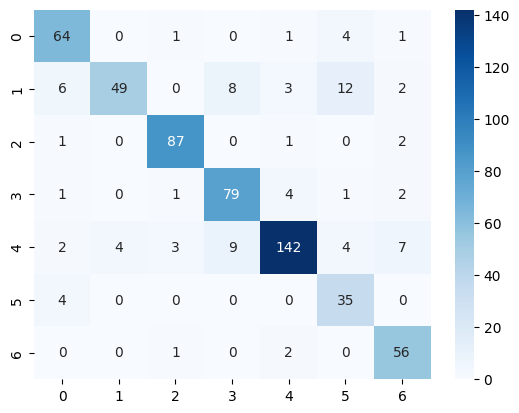

In [57]:
model = GINMLP(num_features=data.num_features, num_classes=dataset.num_classes)
model.reset_parameters()
model = model.to(device)

train_loader = GraphSAINTRandomWalkSampler(data, walk_length=3, num_steps=10, batch_size=32, sample_coverage=100, shuffle=True)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model = train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=None,
    device=device,
    epoch_fn=graph_saint_epoch,
    epochs=100,
    print_every=5
)

y, y_pred = test(model, data)
f1 = f1_score(y, y_pred, average='micro')
print(f"F1 Score: {f1}")
sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='g', cmap='Blues')

# Graph Pooling

### Enfoque trivial

Utilizo la clase de pytorch geometric que implementa una [GCN](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GCN.html#torch_geometric.nn.models.GCN)

$ \mathbf{z}_i^{l} = W^l \sum_{j \in \mathcal{N}(i) \cup \{i\}} (\frac{\mathbf{x}_j^{l-1}}{\sqrt{d_j d_i}}) + b^l$

$ \mathbf{z}_G = \frac{1}{|V|} * \sum_{v \in V}(\mathbf{z}_v) $

La función de pooling que utilicemos puede ser cualquier operación sobre los nodos de los embeddings que los agregue eliminando la dimensión de los nodos, es decir, que consiga:

$ [num\_nodes, hidden\_dim] \to [hidden\_dim]$

Además, esta operación debe ser invariante al orden puesto que en un grafo, a diferencia de otro tipo de dato, no existe un orden fijo para los nodos. Por ejemplo, la media o la suma son buenos candidatos, mientras que la concatenación no.

A continuación implementamos una red de grafos convolucional (GCN) que usa la media como pooling.

In [58]:
class GCNGraph(Module):
    def __init__(self, num_features, num_classes, hidden_channels=32, n_layers=2):
        super(GCNGraph, self).__init__()
        self.gcn = GCN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
            jk="cat",
            dropout=0.5    
        )
        self.cls = MLP(
            in_channels=hidden_channels, 
            hidden_channels=hidden_channels,
            out_channels=num_classes, 
            num_layers=2,
            dropout=0.5
        )
    
    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.gcn(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.cls(x)
        return x

Para comprobar que funciona, usaremos un dataset de clasificación a nivel de grafos con estructuras de proteínas.

In [59]:
dataset = TUDataset(root='MoleculeNet', name='PROTEINS')

print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Label distribution: {Counter([data.y.item() for data in dataset])}")

Number of graphs: 1113
Number of features: 3
Number of classes: 2
Label distribution: Counter({0: 663, 1: 450})


Como podemos ver, existe cierto desbalance con respecto a las etiquetas de los grafos, siendo la clase positiva minoritaria. Para solventarlo realizaremos oversampling de esta clase _copiando_ de manera aleaoria grafos hasta tener el mismo número de grafos para cada una de las clases.

In [60]:
def split_graph_dataset(dataset, test_size=0.2, oversample=True):
    train_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=test_size, stratify=[data.y.item() for data in dataset])

    if oversample:
        # Oversamplear la clase minoritaria
        clss0 = torch.argwhere(dataset[train_idx].y == 0).flatten()
        clss1 = torch.argwhere(dataset[train_idx].y == 1).flatten()
        clss1 = torch.tensor(np.random.choice(clss1, len(clss0), replace=True))
        # Concatenamos ambas clases ya balanceadas
        train_idx = torch.cat([torch.tensor(train_idx[clss1]), torch.tensor(train_idx[clss0])], axis=0)

        print(f"Number of training graphs: {len(train_idx)}, Labels: {Counter([dataset[i].y.item() for i in train_idx])}")
        print(f"Number of test graphs: {len(test_idx)}, Labels: {Counter([dataset[i].y.item() for i in test_idx])}")

    train_loader = DataLoader(dataset[train_idx], batch_size=128, shuffle=True)
    test_loader = DataLoader(dataset[test_idx], batch_size=len(test_idx))
    return train_loader, test_loader

train_loader, test_loader = split_graph_dataset(dataset, test_size=0.2, oversample=True)

Number of training graphs: 1060, Labels: Counter({1: 530, 0: 530})
Number of test graphs: 223, Labels: Counter({0: 133, 1: 90})


In [61]:
def _graph_epoch(model, train_loader, optimizer, criterion, device):
    epoch_loss = 0
    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss/len(train_loader)

In [62]:
model = GCNGraph(num_features=dataset.num_features, num_classes=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, optimizer, criterion, device, epoch_fn=_graph_epoch, epochs=200, print_every=10)

Epoch 0: Loss 0.7194126314587064
Epoch 10: Loss 0.6537854075431824
Epoch 20: Loss 0.6318001415994432
Epoch 30: Loss 0.5956152611308627
Epoch 40: Loss 0.608372151851654
Epoch 50: Loss 0.5948043134477403
Epoch 60: Loss 0.5887563692198859
Epoch 70: Loss 0.5969313449329801
Epoch 80: Loss 0.60214673810535
Epoch 90: Loss 0.5902039210001627
Epoch 100: Loss 0.5817800429132249
Epoch 110: Loss 0.5933742059601678
Epoch 120: Loss 0.5816455748346117
Epoch 130: Loss 0.5777986976835463
Epoch 140: Loss 0.5844413240750631
Epoch 150: Loss 0.5606119301584032
Epoch 160: Loss 0.558042910363939
Epoch 170: Loss 0.5564183228545718
Epoch 180: Loss 0.5663188795248667
Epoch 190: Loss 0.5772489176856147


### Pooling con RNNs y Atención

$ \mathbf{q}_t = \text{GRU}(\mathbf{o}_{t-1}, \mathbf{q}_{t-1}) $

$ e_{v,t} = \sum \mathbf{z}_v \odot \mathbf{q}_t $

$ a_{v,t} = \frac{\exp(e_{v,t})}{\sum_{u \in \mathcal{V}} \exp(e_{u,t})} $

$ \mathbf{o}_t = \sum_{v \in \mathcal{V}} a_{v,t} \mathbf{z}_v $

$z_G = (o_1 \oplus o_2 \oplus ... \oplus o_T) $

Para obtener la query utilizamos cualquier red de la familia de las RNNs, para este caso implementaremos una GRU.

In [63]:
class UpdateGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        """
        Custom GRU based on the given equations.
        
        Args:
            input_dim (int): Dimension of the input vector x.
            hidden_dim (int): Dimension of the hidden state h.
        """
        super(UpdateGRU, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Input-to-hidden weights and biases
        self.W_ir = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_iz = nn.Linear(input_dim, hidden_dim, bias=True)
        self.W_in = nn.Linear(input_dim, hidden_dim, bias=True)
        
        # Hidden-to-hidden weights and biases
        self.W_hr = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_hz = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.W_hn = nn.Linear(hidden_dim, hidden_dim, bias=True)
        
        # Activation functions
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def reset_parameters(self):
        self.W_ir.reset_parameters()
        self.W_iz.reset_parameters()
        self.W_in.reset_parameters()
        self.W_hr.reset_parameters()
        self.W_hz.reset_parameters()
        self.W_hn.reset_parameters()

    def forward(self, x_t, h_t_minus_1):
        """
        Forward pass for a single time step.
        
        Args:
            x_t (torch.Tensor): Input vector at time t, shape (batch_size, input_dim).
            h_t_minus_1 (torch.Tensor): Hidden state at time t-1, shape (batch_size, hidden_dim).
        
        Returns:
            h_t (torch.Tensor): Updated hidden state at time t, shape (batch_size, hidden_dim).
        """
        # Compute reset gate
        r_t = self.sigmoid(self.W_ir(x_t) + self.W_hr(h_t_minus_1))
        
        # Compute update gate
        z_t = self.sigmoid(self.W_iz(x_t) + self.W_hz(h_t_minus_1))
        
        # Compute candidate hidden state
        n_t = self.tanh(self.W_in(x_t) + r_t * self.W_hn(h_t_minus_1))
        
        # Compute new hidden state
        h_t = (1 - z_t) * n_t + z_t * h_t_minus_1
        
        return h_t

El Graph pooling mediante atención puede entenderse a través de 5 pasos:

1. Calculamos `la nueva query` a partir de la antigua salida de atención y de la antigua query (entendemos query como hidden state) con una red de tipo RNN.
2. Calculamos la `similitud entre el embedding de cada nodo y la nueva query` (cualquier función ℝd→ℝ nos vale, normalmente usaremos el producto escalar).
3. Normalizamos las similitudes con una softmax obteniendo los `attention scores`.
4. Se `multiplica cada attention score ([0, 1]) por el valor original del embedding` del nodo ponderando su importancia en el contexto del grafo. La nueva salida será la suma de cada embedding  ponderado.
5. Se `repite del paso 1 al 4 T veces` y finalmente se concatenan las salidas obteniendo el embedding del grafo.

In [64]:
class GlobalGRUPooling(Aggregation):

    def __init__(self, input_dim, T):
        super(GlobalGRUPooling, self).__init__()
        self.gru = UpdateGRU(input_dim, input_dim)
        self.T = T
        self.input_dim = input_dim

    def reset_parameters(self):
        self.gru.reset_parameters()
        self.mlp_alpha.reset_parameters()

    def forward(self, x, index, ptr=None, dim_size=None, dim=-2, max_num_elements=None):
        batch_size = ptr.shape[0]-1

        # Inicializamos la query y la salida "anterior" a 0s
        q = torch.zeros(batch_size, self.input_dim)
        o = torch.zeros(batch_size, self.input_dim)

        outputs = []

        for _ in range(self.T): # PASO 5: REPETIMOS EL PASO 1 AL 4 T VECES
            q = self.gru(o, q) # PASO 1: CALCULAMOS LA NUEVA QUERY (q_t)
            
            q_hat = q[index]
            e =  torch.sum(x * q_hat, dim=1, keepdim=True) # PASO 2: CALCULAMOS LA SIMILIUD ENTRE q_t y x_i
            a = softmax(e, index) # PASO 3: NORMALIZAMOS LOS PESOS DE ATENCION MEDIANTE SOFTMAX

            o = scatter(a*x, index, reduce='sum') # PASO 4: AGREGAMOS LOS VALORES DE x_i PONDERADOS POR LOS PESOS DE ATENCION
            outputs.append(o)

        return torch.cat(outputs, dim=1) # Concatenamos las salidas de cada paso

Implementamos el módulo final que combina una GCN con el attention pooling que hemos diseñado.

In [65]:
class GCNGlobalGRUPooling(Module):

    def __init__(self, num_features, num_classes, hidden_channels=64, n_layers=3, T=5):
        super(GCNGlobalGRUPooling, self).__init__()
        self.gcn = GCN(
            in_channels=num_features,
            hidden_channels=hidden_channels,
            num_layers=n_layers,
            out_channels=hidden_channels,
            dropout=0.5,
            jk="cat",    
        )
    
        self.gru_pooling = GlobalGRUPooling(hidden_channels, T)

        self.cls = MLP(
            in_channels=hidden_channels*T, 
            hidden_channels=hidden_channels,
            out_channels=num_classes, 
            num_layers=2,
            dropout=0.5
        )
    
    def reset_parameters(self):
        self.gcn.reset_parameters()
        self.cls.reset_parameters()
        self.gru_pooling.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.gcn(x, edge_index)
        x = self.gru_pooling(x, data.batch, ptr=data.ptr)
        x = self.cls(x)
        return x

In [66]:
dataset = TUDataset(root='MoleculeNet', name='PROTEINS')
train_loader, test_loader = split_graph_dataset(dataset, test_size=0.2, oversample=True)

Number of training graphs: 1060, Labels: Counter({1: 530, 0: 530})
Number of test graphs: 223, Labels: Counter({0: 133, 1: 90})


In [67]:
model = GCNGlobalGRUPooling(num_features=dataset.num_features, num_classes=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

model = train(model, train_loader, optimizer, criterion, device, epoch_fn=_graph_epoch, epochs=251, print_every=10)

Epoch 0: Loss 0.7187035878499349
Epoch 10: Loss 0.6053749389118619
Epoch 20: Loss 0.5954336656464471
Epoch 30: Loss 0.5635498960812887
Epoch 40: Loss 0.5500713984171549
Epoch 50: Loss 0.558109399345186
Epoch 60: Loss 0.5445935229460398
Epoch 70: Loss 0.5519579682085249
Epoch 80: Loss 0.5342973437574174
Epoch 90: Loss 0.5218126508924696
Epoch 100: Loss 0.5506086779965295
Epoch 110: Loss 0.5305287175708346
Epoch 120: Loss 0.5290973020924462
Epoch 130: Loss 0.532406661245558
Epoch 140: Loss 0.529113683435652
Epoch 150: Loss 0.5204480952686734
Epoch 160: Loss 0.5244384970929887
Epoch 170: Loss 0.5233920845720503
Epoch 180: Loss 0.5295981599224938
Epoch 190: Loss 0.5180932813220553
Epoch 200: Loss 0.5200973914729224
Epoch 210: Loss 0.517094201511807
Epoch 220: Loss 0.5159712963634067
Epoch 230: Loss 0.5276255144013299
Epoch 240: Loss 0.5218139919969771
Epoch 250: Loss 0.5452894734011756


-------